In [1]:
import qcodes as qc
import logging
import os
import tempfile
from sequencebuilder.alazar_config import alazarconfig
import numpy as np
import matplotlib.pyplot as plt
from qcodes.station import Station
from qcodes.utils.dataset.doNd import do0d, do1d
from qcodes import initialise_or_create_database_at, \
    load_or_create_experiment, Measurement, Parameter, \
    Station
from qcodes.dataset.plotting import plot_by_id
from sequencebuilder.awg_controller import AWGController



logging.basicConfig(level=logging.INFO)

In [2]:
db_path = os.path.join(tempfile.gettempdir(),
                       'data_access_example.db')
initialise_or_create_database_at(db_path)

experiment = load_or_create_experiment(
    experiment_name='alazar',
    sample_name='alazar-sample')
SC = qc.Station(config_file="C:\\Users\\Farzad\\Documents\\Rasmus\\QCoDeS-experiment\\ConfigRBC.yaml")

In [3]:

AWGB = SC.load_instrument('AWGB')
seqbuild = AWGController(name = 'seqbuild', awg=AWGB)
SC.add_component(seqbuild)
alazar = SC.load_instrument('alazar')
alazarconfig(alazar, seqmode=True,external_clock=False)
alazar_ctrl = SC.load_instrument('alazar_ctrl')
rec_f1_mag = SC.load_instrument('rec_f1_mag',parent=alazar_ctrl)
rec_f1_phase = SC.load_instrument('rec_f1_phase',parent=alazar_ctrl)


INFO:qcodes.instrument.base.com.visa:[AWGB(AWG5208)] Opening PyVISA Resource Manager with default backend.
INFO:qcodes.instrument.base.com.visa:[AWGB(AWG5208)] Opening PyVISA resource at address: TCPIP0::192.168.15.118::inst0::INSTR
INFO:qcodes.instrument.base:[AWGB(AWG5208)] Connected to instrument: {'vendor': 'TEKTRONIX', 'model': 'AWG5208', 'serial': 'B020203', 'firmware': 'FV:6.1.0061.0'}


Connected to: TEKTRONIX AWG5208 (serial:B020203, firmware:FV:6.1.0061.0) in 0.18s


In [4]:
SC.seqbuild.cycle_time = 4e-6
SC.seqbuild.pulse_time = 0.6e-6
SC.seqbuild.readout_time = 1.5e-6
SC.seqbuild.marker_offset = 0e-9
SC.seqbuild.SR.set(1.5e9)
SC.seqbuild.readout_freq_1(6.6104e9)


In [5]:
npts = 100
start = 4.5e3
stop = 5.0e6
SC.seqbuild.MultiQ_SSB_Spec_NoOverlap(start, stop, npts)

In [6]:
#SC.seqbuild.seq.plot()

In [ ]:
SC.seqbuild.seq.plot_elem_nr(60)

In [ ]:
SC.seqbuild.uploadToAWG()

In [ ]:
SC.seqbuild.runAWG()

In [7]:
SC.seqbuild.awg.run_state()

'Running'

In [ ]:
print(SC.seqbuild.awg.ch1.state())
print(SC.seqbuild.awg.ch2.state())
print(SC.seqbuild.awg.ch3.state())
print(SC.seqbuild.awg.ch4.state())

In [8]:
#SC.seqbuild.awg.stop()
alazar_ctrl.channels.append(rec_f1_mag)
alazar_ctrl.channels.append(rec_f1_phase)

In [14]:
USE_DEMOD_FREQ = 20e6
alazar_ctrl.channels[0].demod_freq(USE_DEMOD_FREQ)
alazar_ctrl.channels[1].demod_freq(USE_DEMOD_FREQ)
alazar_ctrl.int_time(0.6e-6)
alazar_ctrl.int_delay(0E-9)
num_averages = 800
for ala_chan in alazar_ctrl.channels[0:2]:
    ala_chan.num_averages(num_averages)
    ala_chan.records_per_buffer(npts)
    ala_chan.data.setpoint_labels = ('SSB Drive frequency (Non-overlap)',)
    ala_chan.data.setpoint_units = ('Hz',)
    ala_chan.prepare_channel()
#alazar_ctrl.int_time(SC.seqbuild.readout_time)






INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 600.0 samples round up to 640
INFO:qdev_wrappers.alazar_controllers.ATSChannelController:need 600.0 samples round up to 640


In [15]:
data1 = do0d(alazar_ctrl.channels[0:2].data)

INFO:qcodes.dataset.measurements:Registered alazar_ctrl_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered alazar_ctrl_records in the Measurement.
INFO:qcodes.dataset.measurements:Registered alazar_ctrl_rec_f1_mag_data in the Measurement.
INFO:qcodes.dataset.measurements:Registered alazar_ctrl_rec_f1_phase_data in the Measurement.
INFO:qcodes.dataset.sqlite.queries:Set the run_timestamp of run_id 206 to 1615307923.1851478
INFO:qcodes.dataset.measurements:Starting measurement with guid: aaaaaaaa-0000-0000-0000-017817dade61. 
INFO:qcodes.dataset.measurements:Using background writing: False
INFO:qdev_wrappers.alazar_controllers.alazar_multidim_parameters:calling acquire with {'samples_per_record': 640, 'records_per_buffer': 100, 'buffers_per_acquisition': 800, 'allocated_buffers': 4}


Starting experimental run with id: 206. 


INFO:qcodes.dataset.measurements:Finished measurement with guid: aaaaaaaa-0000-0000-0000-017817dade61. 


([<AxesSubplot:title={'center':'Run #206, Experiment alazar (alazar-sample)'}, xlabel='SSB Drive frequency (Non-overlap) (Hz)', ylabel='I (In-phase) (μV)'>,
  <AxesSubplot:title={'center':'Run #206, Experiment alazar (alazar-sample)'}, xlabel='SSB Drive frequency (Non-overlap) (Hz)', ylabel='Q (Quadrature) (μV)'>],
 [None, None])

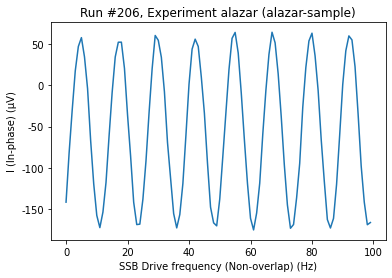

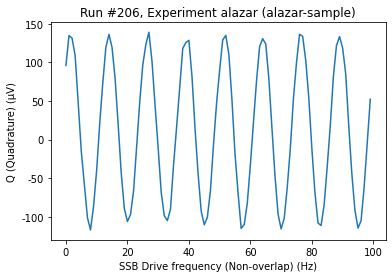

In [16]:
plot_by_id(data1[0].run_id)